Importing the libraries

In [ ]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from keras import layers

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, ReLU, Activation, Add, Dense, BatchNormalization, ZeroPadding2D, Input, Flatten, AveragePooling2D, MaxPooling2D
from keras.initializers import random_uniform, glorot_uniform, constant, identity

def identity_block(X, f, filters, training = False, initializer = random_uniform):
  F1, F2, F3 = filters

  X_shortcut = X
  cache = []

  # First Component of main path
  X = Conv2D(F1, (1, 1), strides = (1, 1), padding = "valid", kernel_initializer=initializer(seed = 0))(X)
  X = BatchNormalization(axis = 3)(X, training = training)
  X = Activation('relu')(X)

  # Second Component of main path
  X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same', kernel_initializer=initializer(seed = 0))(X)
  X = BatchNormalization(axis = 3)(X, training = training)
  X = Activation('relu')(X)

  # Third Component of main path
  X = Conv2D(F3, (1, 1), strides = (1, 1), padding = "valid", kernel_initializer=initializer(seed = 0))(X)
  X = BatchNormalization(axis = 3)(X, training = training)

  # Skip Component
  X = Add()([X_shortcut, X])
  X = Activation('relu')(X)

  return X

In [ ]:
def convolution_block(X, f, filters, s = 2, training = True, initializer = glorot_uniform):
  F1, F2, F3 = filters
  X_shortcut = X
  cache = []

  # First component of main path
  X = Conv2D(F1, (1, 1), padding = "valid", strides = (s, s), kernel_initializer = initializer(seed = 0))(X)
  X = BatchNormalization(axis = 3)(X, training = training)
  X = Activation('relu')(X)

  # Second component of main path
  X = Conv2D(F2, (f, f), padding = "same", strides = (1, 1), kernel_initializer = initializer(seed = 0))(X)
  X = BatchNormalization(axis = 3)(X, training = training)
  X = Activation('relu')(X)

  # Third component of main path
  X = Conv2D(F3, (1, 1), padding = "valid", strides = (1, 1), kernel_initializer = initializer(seed = 0))(X)
  X = BatchNormalization(axis = 3)(X, training = training)

  # Skip component path
  X_shortcut = Conv2D(F3, (1, 1), padding = "valid", strides = (s, s), kernel_initializer = initializer(seed = 0))(X_shortcut)
  X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)

  # Skip component
  X = Add()([X_shortcut, X])
  X = Activation('relu')(X)

  return X

In [ ]:
from keras.models import Model, load_model
def resnet50(input_shape = (64, 64, 3), classes = 6):
  # Input layer
  X_input = Input(input_shape)

  # Stage 0
  X = ZeroPadding2D((3, 3))(X_input)

  # Stage 1
  X = Conv2D(64, (7,7), strides = (2, 2), kernel_initializer=glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3, 3), strides = (2, 2))(X)

  # Stage 2
  X = convolution_block(X, f = 3, filters = (64, 64, 256), s = 1)
  for i in range(2):
    X = identity_block(X , 3, (64, 64, 256))

  # Stage 3
  X = convolution_block(X, f = 3, filters = (128, 128, 512), s = 2)
  for i in range(3):
    X = identity_block(X, f = 3, filters = (128, 128, 512))

  # Stage 4
  X = convolution_block(X, f = 3, filters = (256, 256, 1024), s = 2)
  for i in range(5):
    X = identity_block(X, f = 3, filters = (256, 256, 1024))

  # Stage 5
  X = convolution_block(X, f = 3, filters = (512, 512, 2048), s = 2)
  for i in range(2):
    X = identity_block(X, f = 3, filters = (512, 512, 2048))

  # Final Stage
  X = AveragePooling2D((2, 2))(X)
  X = Flatten()(X)

  # Output layer
  X = Dense(units = classes, activation = 'softmax', kernel_initializer = glorot_uniform(seed = 0))(X)

  model = Model(inputs = X_input, outputs = X)
  return model

In [ ]:
model = resnet50(input_shape = (64, 64, 3), classes = 6)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 70, 70, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           9472      ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['conv2d[0][0]']          

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
def load_dataset(train_file, test_file):
  train_dataset = h5py.File(train_file, 'r')
  train_set_x_orig = np.array(train_dataset['train_set_x'])
  train_set_y_orig = np.array(train_dataset['train_set_y'])

  test_dataset = h5py.File(test_file, 'r')
  test_set_x_orig = np.array(test_dataset['test_set_x'])
  test_set_y_orig = np.array(test_dataset['test_set_y'])

  classes = np.array(test_dataset['list_classes'])

  train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
  test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

  return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [ ]:
X_train_orig, y_train_orig, X_test_orig, y_test_orig, classes = load_dataset("train_signs.h5", "test_signs.h5")

X_train = X_train_orig/255
X_test = X_test_orig/255
from sklearn.preprocessing import OneHotEncoder
y_train = OneHotEncoder(categories = 'auto', sparse_output = False).fit_transform(y_train_orig.reshape(-1, 1))
y_test = OneHotEncoder(categories = 'auto', sparse_output = False).fit_transform(y_test_orig.reshape(-1, 1))

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

[[5 0 2 ... 2 4 5]]
number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


[]

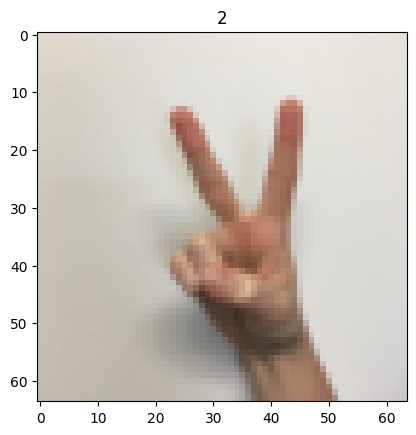

In [ ]:
plt.imshow(X_train_orig[321])
plt.title(y_train_orig[0][321])
plt.plot()

In [ ]:
model.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
34/34 [==============================] - 59s 114ms/step - loss: 2.6800 - accuracy: 0.3880
Epoch 2/10
34/34 [==============================] - 2s 55ms/step - loss: 0.8813 - accuracy: 0.6602
Epoch 3/10
34/34 [==============================] - 2s 55ms/step - loss: 0.4787 - accuracy: 0.8241
Epoch 4/10
34/34 [==============================] - 2s 55ms/step - loss: 0.4145 - accuracy: 0.8500
Epoch 5/10
34/34 [==============================] - 2s 67ms/step - loss: 0.3515 - accuracy: 0.8694
Epoch 6/10
34/34 [==============================] - 2s 60ms/step - loss: 0.1958 - accuracy: 0.9315
Epoch 7/10
34/34 [==============================] - 2s 55ms/step - loss: 0.1291 - accuracy: 0.9593
Epoch 8/10
34/34 [==============================] - 2s 55ms/step - loss: 0.1320 - accuracy: 0.9565
Epoch 9/10
34/34 [==============================] - 2s 56ms/step - loss: 0.1185 - accuracy: 0.9602
Epoch 10/10
34/34 [==============================] - 2s 56ms/step - loss: 0.1978 - accuracy: 0.9370


In [ ]:
preds = model.evaluate(X_test, y_test)
print(f"Loss = {str(preds[0])}\nTest Accuracy = {str(preds[1])}")

4/4 [==============================] - 2s 32ms/step - loss: 0.2411 - accuracy: 0.9083
Loss = 0.24112768471240997
Test Accuracy = 0.9083333611488342


Input Image shape:  (1, 64, 64, 3)


[]

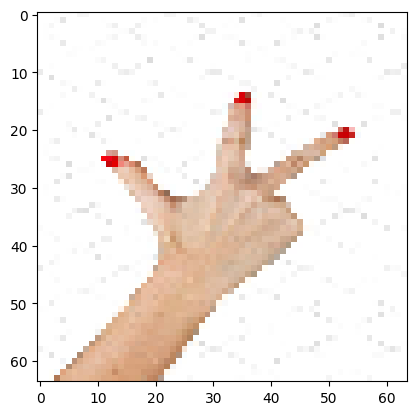

In [ ]:
from keras.preprocessing import image

img = image.load_img('sample2.jpg', target_size = (64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = x/255.0
print("Input Image shape: ", x.shape)
plt.imshow(img)
plt.plot()

In [ ]:
pred = model.predict(x)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", pred)
print("Predicted Class: ", np.argmax(pred))

1/1 [==============================] - 0s 33ms/step
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] =  [[2.6148204e-03 8.0659847e-06 1.0514468e-02 6.1792538e-02 8.5840243e-01
  6.6667669e-02]]
Predicted Class:  4


In [ ]:
import tensorflow as tf
model = resnet50(input_shape = (64, 64, 3), classes = 6)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)
history = model.fit(train_dataset, epochs = 25, validation_data = test_dataset)

Epoch 1/25
34/34 [==============================] - 41s 137ms/step - loss: 3.1329 - accuracy: 0.3259 - val_loss: 1.5276 - val_accuracy: 0.3250
Epoch 2/25
34/34 [==============================] - 2s 61ms/step - loss: 1.1944 - accuracy: 0.5352 - val_loss: 1.8538 - val_accuracy: 0.3667
Epoch 3/25
34/34 [==============================] - 2s 59ms/step - loss: 0.9302 - accuracy: 0.6741 - val_loss: 1.2599 - val_accuracy: 0.5500
Epoch 4/25
34/34 [==============================] - 2s 59ms/step - loss: 0.8234 - accuracy: 0.7250 - val_loss: 1.0657 - val_accuracy: 0.6000
Epoch 5/25
34/34 [==============================] - 2s 59ms/step - loss: 0.5324 - accuracy: 0.8194 - val_loss: 0.9378 - val_accuracy: 0.6667
Epoch 6/25
34/34 [==============================] - 2s 69ms/step - loss: 0.2994 - accuracy: 0.8898 - val_loss: 0.9561 - val_accuracy: 0.7750
Epoch 7/25
34/34 [==============================] - 2s 64ms/step - loss: 0.3124 - accuracy: 0.9009 - val_loss: 0.5672 - val_accuracy: 0.7750
Epoch 8/25


In [ ]:
preds = model.evaluate(X_test, y_test)
print(f"Loss = {str(preds[0])}\nTest Accuracy = {str(preds[1])}")

pred = model.predict(x)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", pred)
print("Predicted Class: ", np.argmax(pred))

4/4 [==============================] - 1s 29ms/step - loss: 0.2131 - accuracy: 0.9500
Loss = 0.21314381062984467
Test Accuracy = 0.949999988079071
1/1 [==============================] - 0s 31ms/step
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] =  [[2.6148204e-03 8.0659847e-06 1.0514468e-02 6.1792538e-02 8.5840243e-01
  6.6667669e-02]]
Predicted Class:  4


[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Accuracy')]

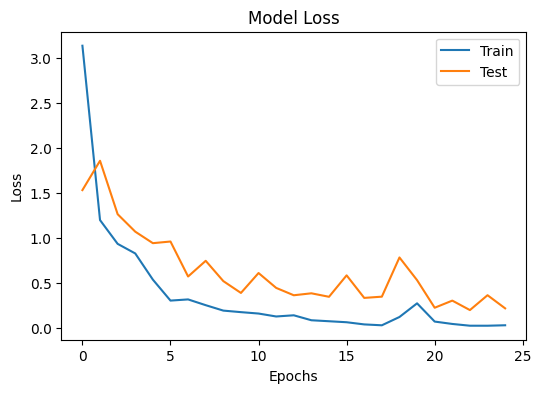

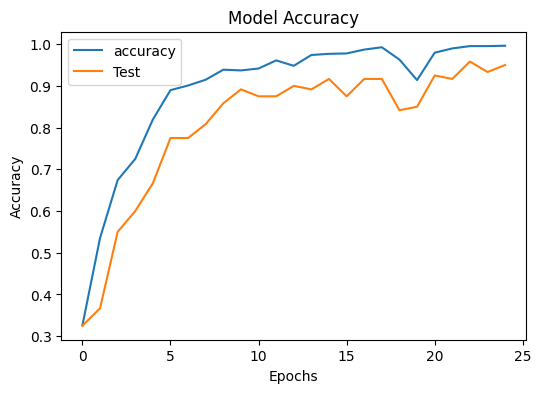

In [ ]:
ds = pd.DataFrame(history.history)
ds_loss = ds[['loss', 'val_loss']].copy()
ds_loss.rename(columns = {'loss':'Train', 'val_loss':'Test'}, inplace = True)
ds_loss.plot(title = "Model Loss", figsize = (6, 4)).set(xlabel = "Epochs", ylabel = "Loss")

ds_acc = ds[['accuracy', 'val_accuracy']].copy()
ds_acc.rename(columns = {'acc':'Train', 'val_accuracy':'Test'}, inplace = True)
ds_acc.plot(title = "Model Accuracy", figsize = (6, 4)).set(xlabel = "Epochs", ylabel = "Accuracy")

In [ ]:
model.save('finger_digits.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('finger_digits.keras')